In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import (
    train_test_split, KFold, RandomizedSearchCV, cross_val_score)
from sklearn.metrics import (r2_score, mean_squared_error, make_scorer)
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, LabelEncoder
)
from sklearn.model_selection import ParameterSampler

import itertools
import random

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
warnings.filterwarnings('ignore')

# Import Dataset Following EDA

In [ ]:
df_filtered = pd.read_csv("Worker_EDA_Complete.csv")

In [ ]:
df_filtered

,tottr,hhmem,mode_category,duration_min,trip_distance_miles,city_from_zip,gender,age,citizen,driver_license,...,transmission,cylinders,veh_type,departure_datetime,departure_hour,day_of_week,month,season,is_weekend,time_of_day
0,3.0,2.0,Auto Driver,20.0,3.619057,Greater Los Angeles Area,1.0,46.0,1.0,1.0,...,1.0,4.0,2.0,2012-05-12 08:15:00,8,Saturday,May,Spring,Weekend,Morning
1,5.0,4.0,Auto Driver,20.0,3.587950,Greater Los Angeles Area,1.0,46.0,1.0,1.0,...,1.0,4.0,2.0,2012-05-12 15:30:00,15,Saturday,May,Spring,Weekend,Afternoon
2,2.0,1.0,Auto Driver,25.0,19.351621,Greater Los Angeles Area,1.0,46.0,1.0,1.0,...,1.0,4.0,2.0,2012-05-12 16:30:00,16,Saturday,May,Spring,Weekend,Afternoon
3,2.0,1.0,Auto Driver,15.0,6.451126,Greater Los Angeles Area,1.0,46.0,1.0,1.0,...,1.0,4.0,2.0,2012-05-12 17:40:00,17,Saturday,May,Spring,Weekend,Afternoon
4,2.0,1.0,Auto Driver,20.0,17.657172,Greater Los Angeles Area,1.0,46.0,1.0,1.0,...,1.0,4.0,2.0,2012-05-12 18:40:00,18,Saturday,May,Spring,Weekend,Evening
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94686,1.0,0.0,Auto Driver,4.0,0.181507,San Francisco Bay Area,1.0,45.0,1.0,1.0,...,0.0,0.0,0.0,2013-01-30 15:58:00,15,Wednesday,January,Winter,Weekday,Afternoon
94687,1.0,0.0,Auto Driver,14.0,2.674467,San Francisco Bay Area,1.0,45.0,1.0,1.0,...,0.0,0.0,0.0,2013-01-30 16:33:00,16,Wednesday,January,Winter,Weekday,Afternoon
94688,1.0,0.0,Active Transportation,17.0,2.621383,San Francisco Bay Area,1.0,45.0,1.0,1.0,...,0.0,0.0,0.0,2013-01-30 17:08:00,17,Wednesday,January,Winter,Weekday,Afternoon
94689,1.0,0.0,Active Transportation,94.0,10.356760,San Francisco Bay Area,1.0,45.0,1.0,1.0,...,0.0,0.0,0.0,2013-01-30 17:43:00,17,Wednesday,January,Winter,Weekday,Afternoon


After importing of a csv, we need to modfiy columns to specific datetypes and remove redundant columns.

In [ ]:
df_filtered['departure_datetime'] = pd.to_datetime(df_filtered['departure_datetime'])
df_filtered.drop(columns=["employment", "student"], inplace=True)

# Inital Model Fitting for Identification of All Feature Importances

In [ ]:
def selected_feature(data):
    
    feature_selected = df_filtered.select_dtypes(include=['number']).columns.tolist()

    selected_data = data[feature_selected]
    
    return selected_data

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# Assume df is your DataFrame and 'y' is the target column

# Step 1: Split the data into train (70%) and temp (30%)
train_df, temp_df = train_test_split(df_filtered, test_size=0.3, stratify=df_filtered['mode_category'], random_state=42)

# Step 2: Split the temp set into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['mode_category'], random_state=42)

# Step 3: Separate features (X) and target (y) for the training set
X_train = selected_feature(train_df)
y_train = train_df['mode_category']

# Step 4: Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 5: Print class distribution after SMOTE
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_resampled))

# Step 6: Separate features and target for validation and test sets
X_val = selected_feature(val_df)
y_val = val_df['mode_category']

X_test = selected_feature(test_df)
y_test = test_df['mode_category']

# Outputs
print(f"Training set size: {X_train_resampled.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Class distribution before SMOTE: Counter({'Auto Driver': 48509, 'Active Transportation': 8419, 'Auto Passenger': 7297, 'Transit': 2058})
Class distribution after SMOTE: Counter({'Auto Driver': 48509, 'Auto Passenger': 48509, 'Transit': 48509, 'Active Transportation': 48509})
Training set size: 194036
Validation set size: 14204
Test set size: 14204


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# Assume df is your DataFrame and 'y' is the target column

# Step 1: Split the data into train (70%) and temp (30%)
train_df, temp_df = train_test_split(df_filtered, test_size=0.3, stratify=df_filtered['mode_category'], random_state=42)

# Step 2: Split the temp set into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['mode_category'], random_state=42)

# Step 3: Separate features (X) and target (y) for the training set
X_train = selected_feature(train_df)
y_train = train_df['mode_category']

# Step 4: Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 5: Print class distribution after SMOTE
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_resampled))

# Step 6: Separate features and target for validation and test sets
X_val = selected_feature(val_df)
y_val = val_df['mode_category']

X_test = selected_feature(test_df)
y_test = test_df['mode_category']

# Outputs
print(f"Training set size: {X_train_resampled.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Class distribution before SMOTE: Counter({'Auto Driver': 48509, 'Active Transportation': 8419, 'Auto Passenger': 7297, 'Transit': 2058})
Class distribution after SMOTE: Counter({'Auto Driver': 48509, 'Auto Passenger': 48509, 'Transit': 48509, 'Active Transportation': 48509})
Training set size: 194036
Validation set size: 14204
Test set size: 14204


In [ ]:
model = RandomForestClassifier(random_state=42)

# Fit and predict
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_val)

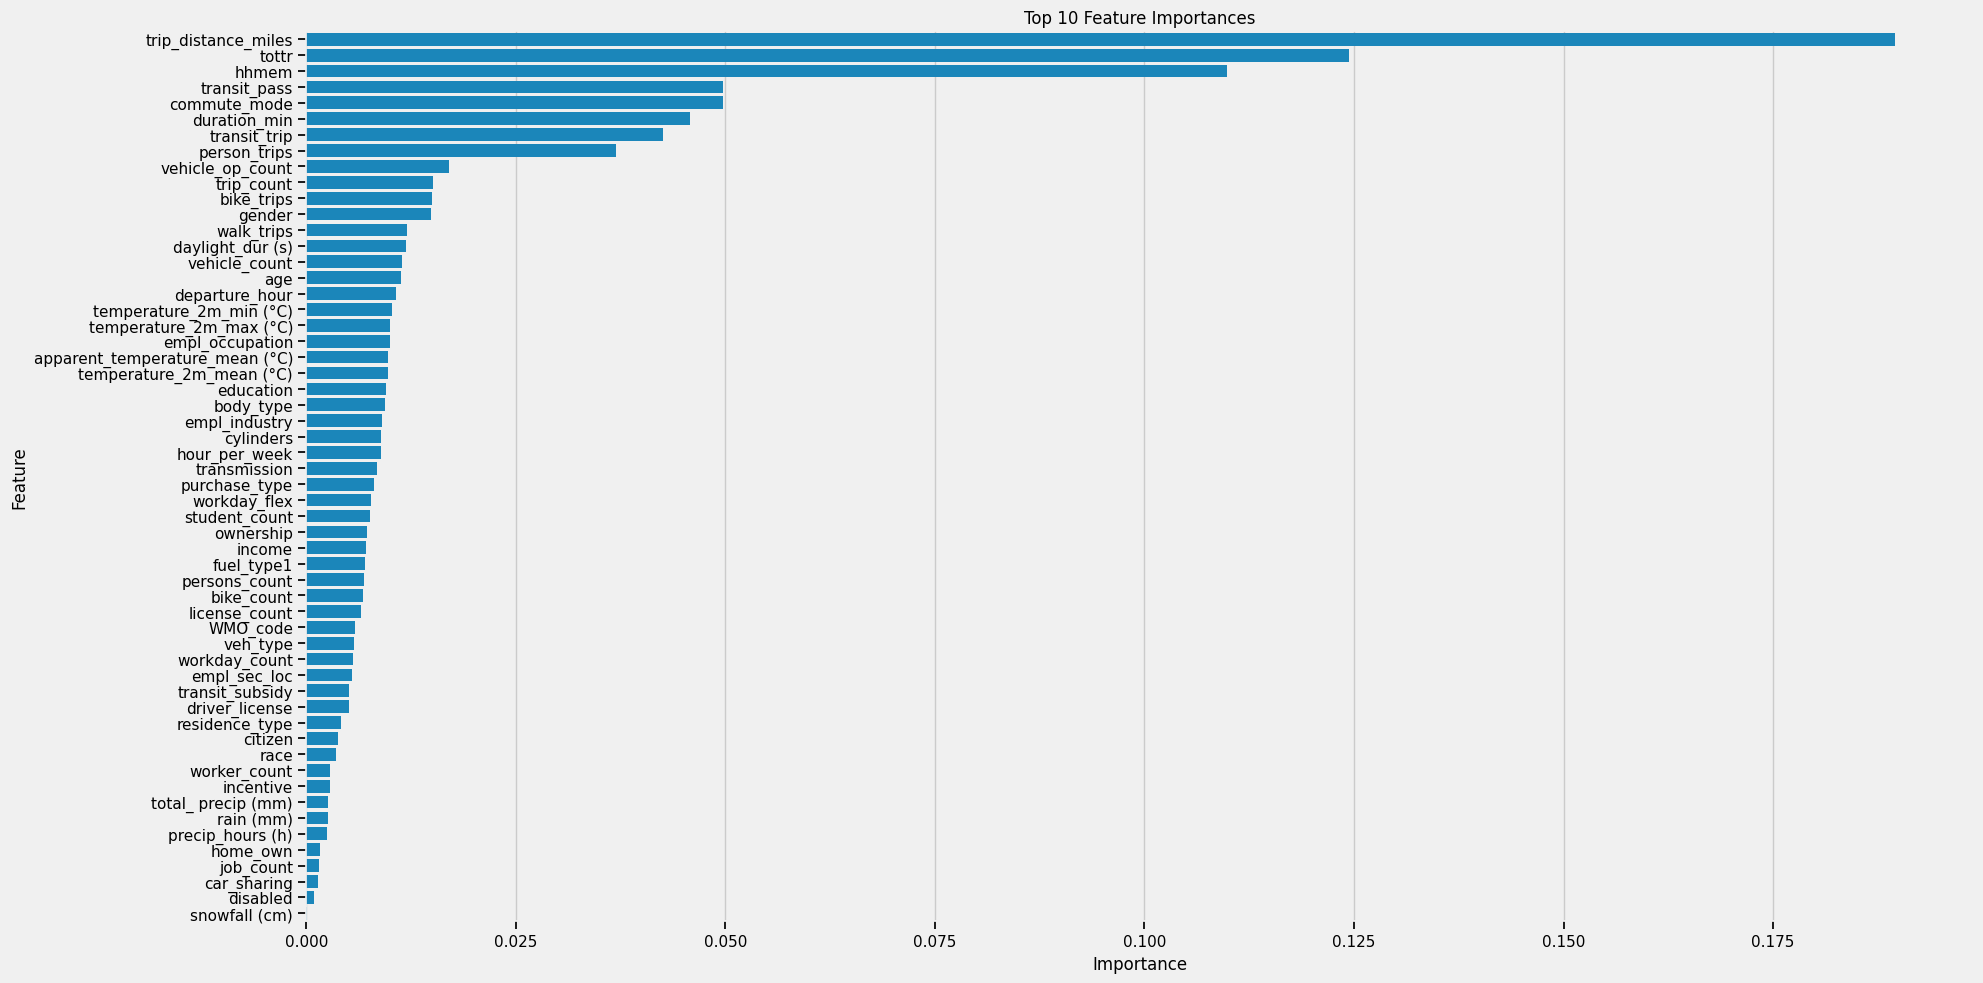

In [ ]:
# Feature importances
importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(20, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(100))
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

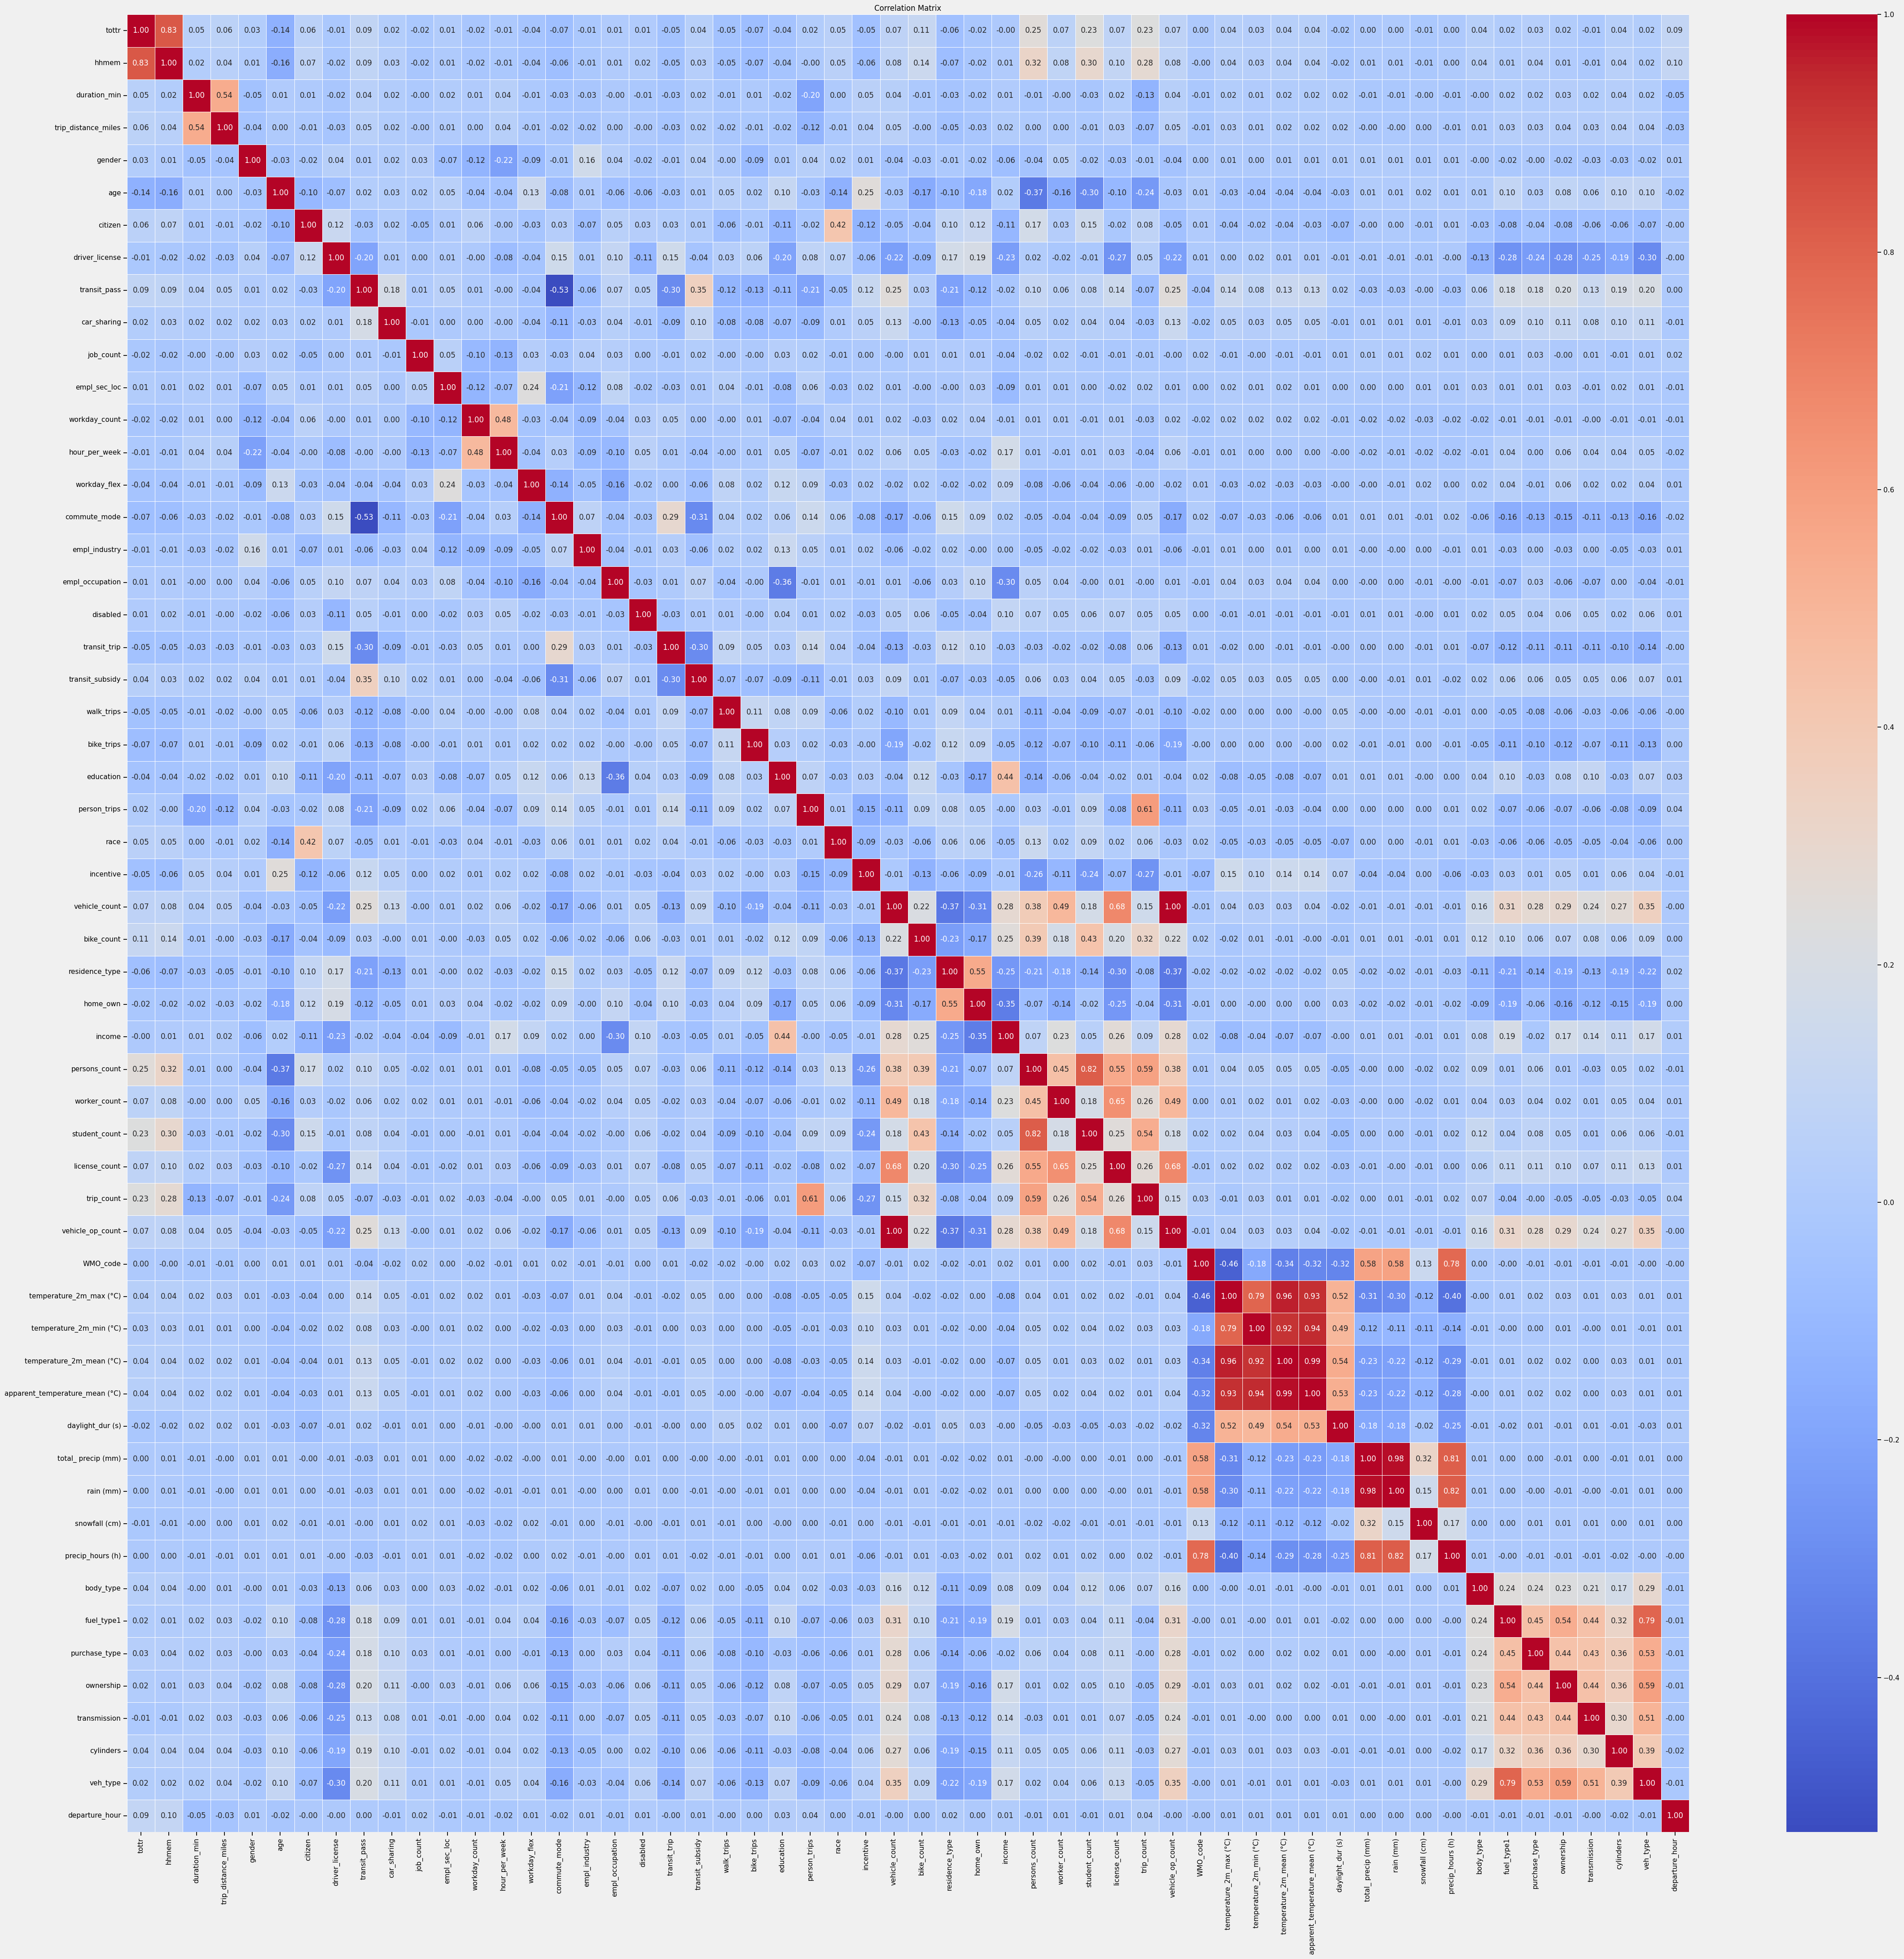

In [ ]:
# Set up a correlation matrix
corr_matrix = X_train.corr()

# Plot heatmap
plt.figure(figsize=(50, 50))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


# Feature Engineering

In [ ]:
import ast

# First convert the units column into an actual list
df_filtered.loc[:, 'workday_range'] = df_filtered['workday_range'].str.strip("[]").str.replace("'", "").str.split(", ")

# Function to handle 'nan' and numbers in a string list
def convert_list_to_int_or_nan(x):
    if isinstance(x, str):
        # Convert string to list using ast.literal_eval
        x = ast.literal_eval(x)

    # Now process the list, convert numeric strings to int and 'nan' to np.nan
    result = []
    for val in x:
        if isinstance(val, str):
            # If it's a string number (e.g., '5.0', '6.0'), convert to float or int
            if val.lower() != 'nan':
                result.append(int(float(val)))  # Convert numeric string to an integer
            else:
                result.append(np.nan)  # Replace 'nan' string with np.nan
        elif isinstance(val, (float, int)):
            result.append(int(val))  # Convert numeric types to integer
        else:
            result.append(np.nan)  # Handle non-numeric values

    return result

# Apply this function to the 'workday_range' column
df_filtered.loc[:, 'workday_range'] = df_filtered['workday_range'].apply(convert_list_to_int_or_nan)

In [ ]:
def check_workday(travel_date, workday_range):
    # If the person works Monday to Friday (8)
    if 8 in workday_range:
        if travel_date == 5 or travel_date == 6:  # Saturday (5) or Sunday (6)
            return 2  # Not a workday
        else:
            return 1  # Monday to Friday is a workday
    # If the person works on specific days in workday_range (1-7)
    elif (travel_date + 1) in workday_range:  # Convert travel_date 0-6 to 1-7 (Monday=1, Sunday=7)
        return 1  # It is a workday
    else:
        return 2  # Not a workday


# Create a new dat of week column with numerical days of week
df_filtered['day_of_week_num'] = df_filtered['departure_datetime'].dt.dayofweek

# Apply the function to the DataFrame
df_filtered['is_workday'] = df_filtered.apply(lambda row: check_workday(row['day_of_week_num'], row['workday_range']), axis=1)


# Display the updated DataFrame with the new 'is_workday' column
print(df_filtered[['day_of_week_num', 'workday_range', 'is_workday']])

       day_of_week_num                      workday_range  is_workday
0                    5  [8, nan, nan, nan, nan, nan, nan]           2
1                    5  [8, nan, nan, nan, nan, nan, nan]           2
2                    5  [8, nan, nan, nan, nan, nan, nan]           2
3                    5  [8, nan, nan, nan, nan, nan, nan]           2
4                    5  [8, nan, nan, nan, nan, nan, nan]           2
...                ...                                ...         ...
94686                2  [8, nan, nan, nan, nan, nan, nan]           1
94687                2  [8, nan, nan, nan, nan, nan, nan]           1
94688                2  [8, nan, nan, nan, nan, nan, nan]           1
94689                2  [8, nan, nan, nan, nan, nan, nan]           1
94690                1  [8, nan, nan, nan, nan, nan, nan]           1

[94691 rows x 3 columns]


In [ ]:
df_filtered

,tottr,hhmem,mode_category,duration_min,trip_distance_miles,city_from_zip,gender,age,citizen,driver_license,...,veh_type,departure_datetime,departure_hour,day_of_week,month,season,is_weekend,time_of_day,day_of_week_num,is_workday
0,3.0,2.0,Auto Driver,20.0,3.619057,Greater Los Angeles Area,1.0,46.0,1.0,1.0,...,2.0,2012-05-12 08:15:00,8,Saturday,May,Spring,Weekend,Morning,5,2
1,5.0,4.0,Auto Driver,20.0,3.587950,Greater Los Angeles Area,1.0,46.0,1.0,1.0,...,2.0,2012-05-12 15:30:00,15,Saturday,May,Spring,Weekend,Afternoon,5,2
2,2.0,1.0,Auto Driver,25.0,19.351621,Greater Los Angeles Area,1.0,46.0,1.0,1.0,...,2.0,2012-05-12 16:30:00,16,Saturday,May,Spring,Weekend,Afternoon,5,2
3,2.0,1.0,Auto Driver,15.0,6.451126,Greater Los Angeles Area,1.0,46.0,1.0,1.0,...,2.0,2012-05-12 17:40:00,17,Saturday,May,Spring,Weekend,Afternoon,5,2
4,2.0,1.0,Auto Driver,20.0,17.657172,Greater Los Angeles Area,1.0,46.0,1.0,1.0,...,2.0,2012-05-12 18:40:00,18,Saturday,May,Spring,Weekend,Evening,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94686,1.0,0.0,Auto Driver,4.0,0.181507,San Francisco Bay Area,1.0,45.0,1.0,1.0,...,0.0,2013-01-30 15:58:00,15,Wednesday,January,Winter,Weekday,Afternoon,2,1
94687,1.0,0.0,Auto Driver,14.0,2.674467,San Francisco Bay Area,1.0,45.0,1.0,1.0,...,0.0,2013-01-30 16:33:00,16,Wednesday,January,Winter,Weekday,Afternoon,2,1
94688,1.0,0.0,Active Transportation,17.0,2.621383,San Francisco Bay Area,1.0,45.0,1.0,1.0,...,0.0,2013-01-30 17:08:00,17,Wednesday,January,Winter,Weekday,Afternoon,2,1
94689,1.0,0.0,Active Transportation,94.0,10.356760,San Francisco Bay Area,1.0,45.0,1.0,1.0,...,0.0,2013-01-30 17:43:00,17,Wednesday,January,Winter,Weekday,Afternoon,2,1


# Feature Selection

In [ ]:
def selected_feature(data):
    
    feature_selected = ['tottr',
                        'gender',
                        'race',
                        'age',
                        'citizen',
                        'incentive',
                        'vehicle_count',
                        'income',
                        'worker_count',
                        'is_workday',
                        'workday_count',
                        'driver_license',
                        'job_count',
                        'apparent_temperature_mean (°C)',
                        'WMO_code']

    selected_data = data[feature_selected]
    
    return selected_data

# Evaluate Performace of the Untuned Model

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# Assume df is your DataFrame and 'y' is the target column

# Step 1: Split the data into train (70%) and temp (30%)
train_df, temp_df = train_test_split(df_filtered, test_size=0.3, stratify=df_filtered['mode_category'], random_state=42)

# Step 2: Split the temp set into validation (15%) and test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['mode_category'], random_state=42)

# Step 3: Separate features (X) and target (y) for the training set
X_train = selected_feature(train_df)
y_train = train_df['mode_category']

# Step 4: Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 5: Print class distribution after SMOTE
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_resampled))

# Step 6: Separate features and target for validation and test sets
X_val = selected_feature(val_df)
y_val = val_df['mode_category']

X_test = selected_feature(test_df)
y_test = test_df['mode_category']

# Outputs
print(f"Training set size: {X_train_resampled.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Class distribution before SMOTE: Counter({'Auto Driver': 48509, 'Active Transportation': 8419, 'Auto Passenger': 7297, 'Transit': 2058})
Class distribution after SMOTE: Counter({'Auto Driver': 48509, 'Auto Passenger': 48509, 'Transit': 48509, 'Active Transportation': 48509})
Training set size: 194036
Validation set size: 14204
Test set size: 14204


In [ ]:
from sklearn.metrics import classification_report, f1_score

# Step 1: Check class distribution
unique, counts = np.unique(y_val, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:", class_distribution)

# Step 2: Generate classification report
report = classification_report(y_val, y_pred, target_names=['Active Transportation', 'Auto Driver', 'Auto Passenger', 'Transit'], digits=3)
print("\nClassification Report:\n", report)

# Step 3: Calculate weighted F1-score
weighted_f1 = f1_score(y_val, y_pred, average='weighted')
print("\nWeighted F1-Score:", weighted_f1)

Class Distribution: {'Active Transportation': 1804, 'Auto Driver': 10395, 'Auto Passenger': 1564, 'Transit': 441}

Classification Report:
                        precision    recall  f1-score   support

Active Transportation      0.889     0.909     0.899      1804
          Auto Driver      0.961     0.967     0.964     10395
       Auto Passenger      0.901     0.839     0.869      1564
              Transit      0.811     0.807     0.809       441

             accuracy                          0.941     14204
            macro avg      0.890     0.881     0.885     14204
         weighted avg      0.940     0.941     0.940     14204


Weighted F1-Score: 0.9403722024458422


In [ ]:
model = RandomForestClassifier(random_state=42)

# Fit and predict
model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_val)


Top 10 Important Features:
                           Feature  Importance
0                            tottr    0.260930
13  apparent_temperature_mean (°C)    0.140344
3                              age    0.132198
6                    vehicle_count    0.075642
14                        WMO_code    0.074565
7                           income    0.064726
10                   workday_count    0.053465
1                           gender    0.049985
2                             race    0.025795
4                          citizen    0.024651


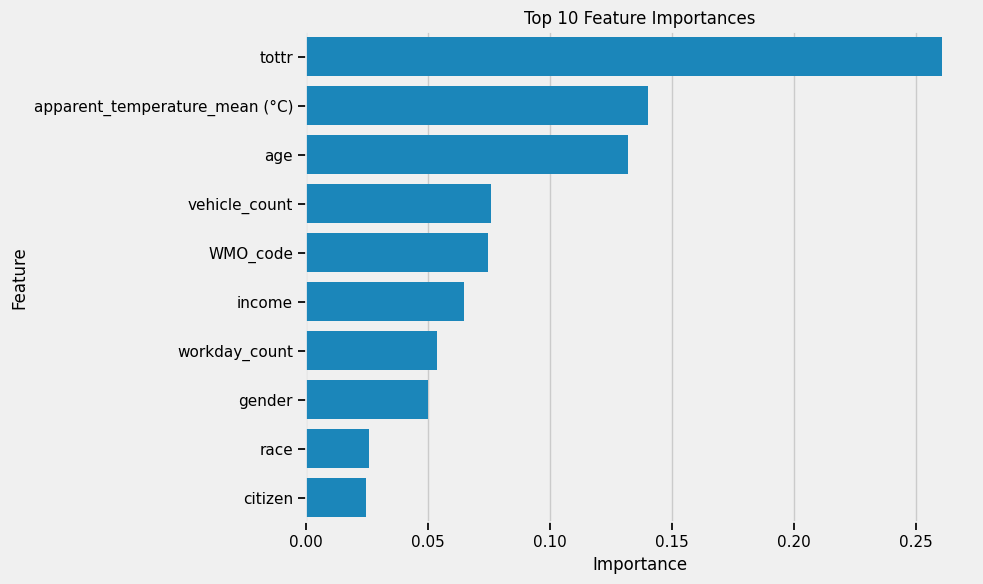

In [ ]:
# Feature importances
importances = model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features
print("\nTop 10 Important Features:")
print(feature_importance_df.head(10))

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

In [ ]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}